**Applied Empirical Analysis (HS 2020)**

**Conny Wunsch, Ulrike Unterhofer and Véra Zabrodina** -- University of Basel

***

# Lab Session 2 - Selection on Observables

***

### Why do we apply semiparametric methods for selection on observables types of analyses?

* Which assumptions can we relax compared to parametric methods?
* Which additional/different assumptions do we impose?
* What types of (potentially different) effects do we identify?
* Which issue do semiparametric methods solve compared to non-parametric methods?

## Application: The Curse and Blessing of Training the Unemployed in a Changing Economy: The Case of East Germany After Unification
**Lechner, M., R. Miquel, and C. Wunsch, German Economic Review 2007**


## 1. Procedure

1. Understand based on which information treatment assignment and self-selection into treatment works (covariate choice should be guided by large observed differences in covariates, institutional knowledge and theoretical considerations)
2. Estimate the treatment probability $Pr(D = 1|X = x)$ parametrically using a probit or logit model:
    * specify a parsimonious model first, then 
    * use omitted variable tests or machine learning methods (e.g. Lasso) to specify full model.
3. Predict the treatment probability, i.e. compute the propensity score $p(X_i)$ (p-score)
4. Check for overlap in p-score across treated and control groups, and possiblydrop non-overlapping ones
5. Choose a semiparametric estimator (IPW, nearest-neighbour matching, radiusmatching, etc.)
6. For inference, bootstrap the whole thing (often implemented in packages)
7. Check for changes in considered population and balancedness in covariates

## 2. Empirical Analysis

### Load Packages and set directory

In [1]:
# remove old objects from R working space
rm(list=ls())

#Load Packages
packages_vector <- c("tidyverse", "haven", "Hmisc", "dplyr", 
                     "tidyr", "stringr", "sandwich", "lmtest", 
                     "jtools", "fBasics", "knitr", "xtable", 
                     "data.table", "stargazer", "AER", 
                     "causalweight", "np")

lapply(packages_vector, require, character.only = TRUE) 


# Function for table display
repr_html.xtable <- function(obj, ...){
    paste(capture.output(print(obj, type = 'html')), collapse="", sep="")
}

# LOAD FUNCTIONS for radiusmatching
  source("radiusmatch.R")
  source("radiusatet.R")
  source("inferenceweights.R")
  source("inferenceweights2.R")


Loading required package: tidyverse

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.1     v dplyr   1.0.0
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: haven

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units


Loading required package: sandwich

Loading required package: lmtest

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loa

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

### Load Data

In [55]:
# Read in Data
load("data_reg_final.RData")
attach(data_reg)

# Define variables (see last session)
y1 <- as.matrix(duration)
y2 <- as.matrix(employed1y)
treat <- as.matrix(treat)
x1 <- as.matrix(dplyr::select(data_reg, xcat_names_reg, 
                              xcont_names, starts_with("quarter_")))
x_names<-colnames(x1)

# Inspect data
head(data_reg)

The following objects are masked from data_reg (pos = 3):

    agegr_2, agegr_3, agegr_4, contr_5y, date_end, date_start,
    duration, educ_0, educ_2, educ_3, educ_99, employed1y, full_time_0,
    id, idobs, insured_earn, lastj_fct_0, lastj_fct_1, lastj_fct_3,
    lastj_fct_99, lastj_occpt_1, lastj_occpt_10, lastj_occpt_11,
    lastj_occpt_12, lastj_occpt_14, lastj_occpt_15, lastj_occpt_16,
    lastj_occpt_17, lastj_occpt_18, lastj_occpt_19, lastj_occpt_2,
    lastj_occpt_20, lastj_occpt_21, lastj_occpt_22, lastj_occpt_23,
    lastj_occpt_3, lastj_occpt_4, lastj_occpt_5, lastj_occpt_6,
    lastj_occpt_7, lastj_occpt_8, lastj_occpt_9, marits_1, num_spells,
    quarter, quarter_1, quarter_2, quarter_3, region_1, region_2,
    region_3, region_4, region_5, region_7, sex_1, spell, swiss_0,
    treat, unempl_r


The following objects are masked from data_reg (pos = 4):

    agegr_2, agegr_3, agegr_4, contr_5y, date_end, date_start,
    duration, educ_0, educ_2, educ_3, educ_99, employed1y,

,id,idobs,date_end,date_start,spell,num_spells,treat,duration,employed1y,insured_earn,...,lastj_fct_1,lastj_fct_3,lastj_fct_99,agegr_2,agegr_3,agegr_4,quarter,quarter_1,quarter_2,quarter_3
,<dbl>,<int>,<date>,<date>,<int>,<int>,<dbl+lbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>
1,1,1,2013-10-22,2013-03-04,1,1,0,233,1,4368,...,0,0,1,1,0,0,1,1,0,0
2,2,2,2013-12-31,2013-04-17,1,1,0,259,1,5579,...,0,0,0,0,1,0,2,0,1,0
3,3,3,2012-02-14,2011-12-20,1,1,1,57,1,2710,...,0,0,0,1,0,0,4,0,0,0
4,5,4,2013-04-01,2013-01-01,1,2,1,91,1,4896,...,0,0,0,0,1,0,1,1,0,0
5,5,5,2013-09-17,2013-07-01,2,2,1,79,1,4896,...,0,0,0,0,1,0,3,0,0,1
6,7,6,2013-03-17,2013-01-07,1,2,1,70,1,5370,...,0,0,1,1,0,0,1,1,0,0


### The propensity score

We start by estimating the p-score manually:

In [56]:
# Estimate the pscore-model
pscore.model <- glm(treat ~ x1, family = binomial(link = "probit"))
summ(pscore.model, , robust = "HC1")

MODEL INFO:
Observations: 19084
Dependent Variable: treat
Type: Generalized linear model
  Family: binomial 
  Link function: probit 

MODEL FIT:
<U+03C7>²(49) = 1474.53, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.10
Pseudo-R² (McFadden) = 0.06
AIC = 24949.22, BIC = 25342.05 

Standard errors: Robust, type = HC1
-----------------------------------------------------
                          Est.   S.E.   z val.      p
---------------------- ------- ------ -------- ------
(Intercept)               0.27   0.05     4.94   0.00
x1sex_1                   0.15   0.02     6.33   0.00
x1marits_1               -0.31   0.02   -14.75   0.00
x1region_1                0.08   0.05     1.48   0.14
x1region_2               -0.04   0.03    -1.10   0.27
x1region_3               -0.00   0.04    -0.13   0.89
x1region_4                0.02   0.04     0.51   0.61
x1region_5               -0.05   0.03    -1.41   0.16
x1region_7               -0.14   0.08    -1.78   0.08
x1swiss_0                -0.02   0.02    -0.

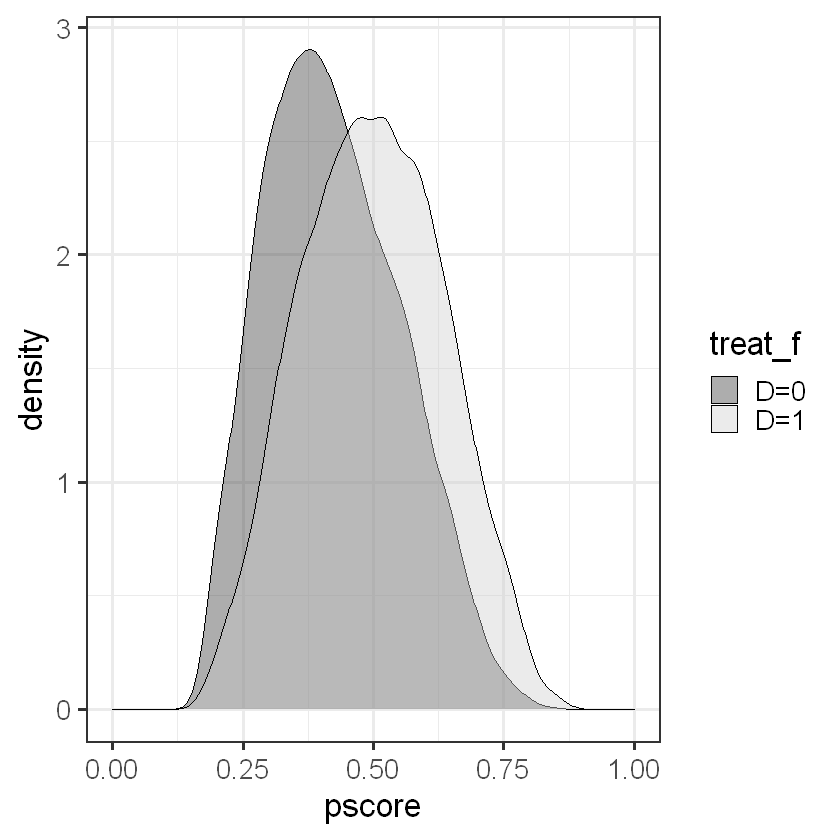

In [57]:
# Predict the pscore and attach it to the data frame
data_reg$pscore <- pscore.model$fitted.values 
# Generate a factor variable for displaying the pscore
data_reg$treat_f <- factor(data_reg$treat, 
                           levels = c(0,1), label = c("D=0", "D=1")) 

# Check for common support in propensity score 
ggplot(data_reg, aes(x = pscore, fill = treat_f)) + 
        geom_density(alpha=0.4) + scale_fill_grey() + 
        theme_bw(base_size = 20) + xlim(0, 1)

### Trimming

We delete treated observations with a p-score larger as the maximum p-score in the control population

In [58]:
print("Sample size before imposing CS")
nrow(data_reg)

# generate an indicator for observations in the CS sample
pscore_max0 <-max(data_reg$pscore[treat==0])
insample<- ifelse(data_reg$pscore <= pscore_max0, 1, 0)
# restrict data to sample with CS
data_reg <- dplyr::filter(data_reg, insample ==1)

print("Sample size after imposing CS")
nrow(data_reg)

# redefine variables that are in the sample of support
y1 <- y1[insample==1]
y2 <- y2[insample==1]
treat <- treat[insample==1]
x1 <- x1[insample==1,]

[1] "Sample size before imposing CS"


[1] 19084

[1] "Sample size after imposing CS"


[1] 19076

### We want to estimate the average treatment effect on the treated:

$$ \text{ATET} = \sum_{i=1}^N\frac{D_iY_i}{\sum_{i=1}^N D_i} - \sum_{i=1}^N\frac{(1-D_i)w(X_i)Y_i}{\sum_{i=1}^N(1-D_i)w(X_i)}$$

### (i) Inverse Probability Weighting

here the weights correspond to $w(X_i)=\frac{p(X_i)}{1-p(X_i)}$

First, we compute the IPW estimator manually (no inference here):

In [59]:
# generate weights based on estimated pscores
data_reg$weight[treat==1] <- 1
data_reg$weight[treat==0] <- data_reg$pscore[treat==0]/
                            (1-data_reg$pscore)[treat==0]
weight <- data_reg$weight

Y1<-sum(y1*treat)/sum(treat)
Y0<-sum(y1*(1-treat)*weight)/sum((1-treat)*weight)
ipw_atet_manual <- Y1-Y0

print("Effect on unemployment duration based on IPW (ATET)")
ipw_atet_manual

# You could impose some additional trimming large values of the pscore 
# by conditioning on some indicator:
# ind=as.numeric((data_reg$pscore<0.05) | (data_reg$pscore>(0.95))) 
# Y1<-sum(y1[ind==0]*treat[ind==0])/sum(treat[ind==0])
# Y0<-sum(y1[ind==0]*(1-treat[ind==0])*weight[ind==0])
# /sum((1-treat[ind==0])*weight[ind==0])

[1] "Effect on unemployment duration based on IPW (ATET)"


[1] -97.63518

Next, we apply the `causalweight` package. Inference and trimming can be applied directly.
For more details, see https://cran.r-project.org/web/packages/causalweight/index.html

In [60]:
# Estimating the ATET based on the causalweight package
ipw_atet <- treatweight(y=y1, d=treat, x=x1, ATET =TRUE, 
                        trim=0.05, boot = 99)
ipw_atet

$effect
[1] -97.6506

$se
[1] 2.002226

$pval
[1] 0

$y1
[1] 103.1038

$y0
[1] 200.7544

$ntrimmed
[1] 0

Does the program have a desirable impact?

###  Check the balancedness of covariates

We compare the differences between the treatment and control group based a selected vector of covariates after reweighting:

In [61]:
# Define a vector of covariates
x_sel <- as.matrix(dplyr::select(data_reg, sex_1, marits_1, 
                                 educ_0, educ_2, educ_3, 
                                 agegr_2, agegr_3, agegr_4, 
                                 swiss_0))
x_sel_names <- colnames(x_sel)

# Define a function estimating the differences 
balanced.model <- function(x){
    
    weighted_diff <- lm(x[insample==1] ~ treat,  weight=data_reg$weight)
    cov <- vcovHC(weighted_diff, type = "HC")
    robust.se <- sqrt(diag(cov))
    
    list( coeff = weighted_diff$coefficients[2], 
        robust.se = robust.se[2], 
        pval = 2*pnorm(-abs(weighted_diff$coefficients[2]/robust.se[2])) )
                    }

diff_output <- apply(x_sel, 2, balanced.model)

# convert list to table
diff_output<-rbindlist(diff_output)
rownames(diff_output)<- x_sel_names

# plot table
print("Differences in X between control and treatment group after reweighting")
xtable(diff_output, digits=3)


[1] "Differences in X between control and treatment group after reweighting"


,coeff,robust.se,pval
sex_1,0.012,0.008,0.116
marits_1,-0.011,0.008,0.156
educ_0,-0.004,0.007,0.516
educ_2,0.002,0.003,0.538
educ_3,0.001,0.006,0.899
agegr_2,-0.002,0.007,0.750
agegr_3,-0.004,0.007,0.541
agegr_4,-0.009,0.006,0.107
swiss_0,-0.001,0.008,0.936


### (ii) Radiusmatching

here the weights are defined  as $w(X_i)=\sum_{j:D_j=1}\frac{\underline{1}(|p(X_j)-p(X_i)|<r)}{|p(X_j)-p(X_i)|}\Big/\sum_{k:D_k=0}\frac{\underline{1}(|p(X_j)-p(X_k)|<r)}{|p(X_j)-p(X_k)|}$

it uses all controls withing a chosen radius $r$.

The `radiusmatching` package by Huber et al (2015) additionally applies some bias correction and is doubly robust (see lecture slides). To download the package, go to https://www.alexandria.unisg.ch/218871/

*Note:  The radius is defined by the multiplier of the maximum distance in pair matching. E.g., setting radius=3 implies a radius of 3 times the maximum distance (or a particular quantile).*

In [62]:
# Applying the radiusmatching package

rmatch_atet <- radiusmatch(y=data_reg$duration, 
                           d=data_reg$treat, 
                           x=x1, 
                           biascorr=1, 
                           commonsup = 1, 
                           radius = 3, 
                           estimand ="ATET", 
                           boot=19 )

print("Effect on unemployment duration based on radiusmatching (ATET)")
rmatch_atet$effect
print("bootstrapped S.E.")
rmatch_atet$se.boot

Warning message in if (class(check) == "try-error") errB = 1 else errB = 0:
"Bedingung hat Länge > 1 und nur das erste Element wird benutzt"
Warning message in if (class(check) == "try-error") errB = 1 else errB = 0:
"Bedingung hat Länge > 1 und nur das erste Element wird benutzt"
Warning message in if (class(check) == "try-error") errB = 1 else errB = 0:
"Bedingung hat Länge > 1 und nur das erste Element wird benutzt"
Warning message in if (class(check) == "try-error") errB = 1 else errB = 0:
"Bedingung hat Länge > 1 und nur das erste Element wird benutzt"
Warning message in if (class(check) == "try-error") errB = 1 else errB = 0:
"Bedingung hat Länge > 1 und nur das erste Element wird benutzt"
Warning message in if (class(check) == "try-error") errB = 1 else errB = 0:
"Bedingung hat Länge > 1 und nur das erste Element wird benutzt"
Warning message in if (class(check) == "try-error") errB = 1 else errB = 0:
"Bedingung hat Länge > 1 und nur das erste Element wird benutzt"
Warning messa

[1] "Effect on unemployment duration based on radiusmatching (ATET)"


[1] -94.97331

[1] "bootstrapped S.E."


[1] 3.572038

### Let's look at some monthly effects
*... going back to the parametric world, we estimate the effects on the individual employment probability up to 2 years after program start.*

**(1) Define monthly employment outcomes**


In [63]:
# Set maximum horizon after start of unemployment
maxdur <- 24

# Monthly employment status
empl <- matrix(0, nrow=nrow(data_reg), ncol=(maxdur))
empl_list <- paste("empl", 1:maxdur, sep="_")
colnames(empl) <- empl_list

for (i in 1:maxdur) {
  empl[,i] = 
  ifelse(data_reg$date_end < data_reg$date_start + 30*i, 1, 0)
}

empl <- as.data.frame(empl, data_reg$treat)
data_reg <- cbind(data_reg, empl)

empl_monthly_treat <- apply(t(empl[treat==1,]),1,mean)
empl_monthly_contr <- apply(t(empl[treat==0,]),1,mean)
month <- rep(1:maxdur)
empl_monthly <- cbind(empl_monthly_treat, empl_monthly_contr, month)
colnames(empl_monthly) <- c("rate_treat", "rate_contr", "month")
empl_monthly <- as.data.frame(empl_monthly)


**(2) Plot monthly employment**

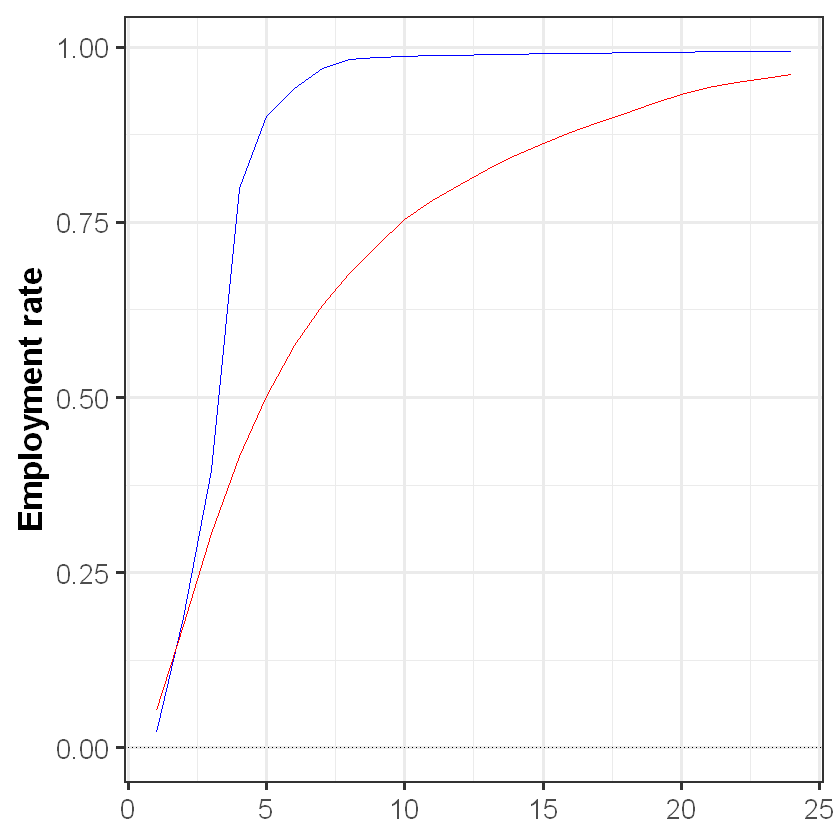

In [64]:
ggplot() +
  geom_line(data = empl_monthly,  aes(x = month, y = rate_treat), 
            color = "blue") +
  geom_line(data = empl_monthly, 
            aes(x = month, y = rate_contr), 
            color = "red") +
  theme_bw(base_size = 20) +
  theme(axis.title = element_text(face = "bold"),
        axis.title.x = element_blank()) +
  ylab("Employment rate") +
  xlab("Months") +
  geom_hline(yintercept = 0, linetype="dotted") 
# legend

**(3) Estimate monthly effects**

Warning message:
"Removed 1 rows containing missing values (geom_point)."


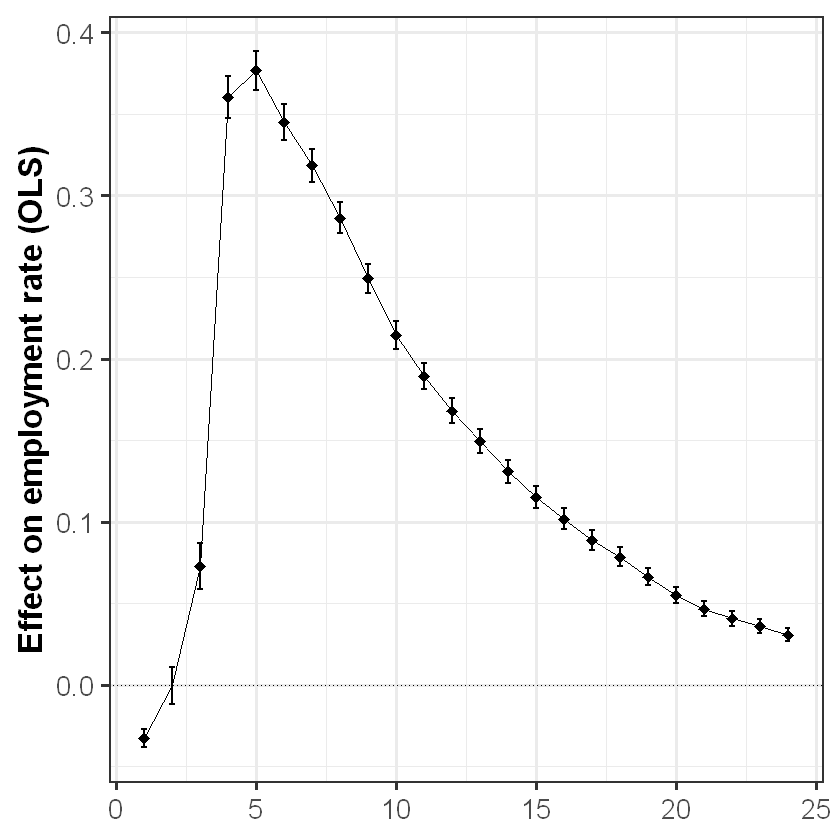

In [65]:
# Define a function
reg_monthly <- function(y) {
    out <- lm(y ~ treat + x1)
    out2 <- coeftest(out, vcov = vcovHC(out))
    list(effect=out2[2,1], se=out2[2,2])
  }

# Graphs with CI and dots for significance
    reg_monthly_out <- apply(empl, 2, reg_monthly)
      reg_monthly_out2 <- rbindlist(reg_monthly_out)
      reg_monthly_out2$month <- rep(1:maxdur)
      reg_monthly_out2$cil <- reg_monthly_out2$effect - 1.96*reg_monthly_out2$se
      reg_monthly_out2$cih <- reg_monthly_out2$effect + 1.96*reg_monthly_out2$se
      reg_monthly_out2$sig <- ifelse(abs(reg_monthly_out2$effect)
                                /reg_monthly_out2$se>1.64, 
                                reg_monthly_out2$effect, NA)

# Plot
ggplot(reg_monthly_out2,                
         aes(x = month, y = effect)) +
    geom_line() +
    geom_point(aes(x = month, y = sig), shape = 18,
               size  = 3) +
    geom_errorbar(aes(ymin  = cil,
                      ymax  = cih),
                  width = 0.2,
                  size  = 0.7) +
  theme_bw(base_size = 20) +
    theme(axis.title = element_text(face = "bold"),
          axis.title.x = element_blank()) +
    ylab("Effect on employment rate (OLS)") +
    geom_hline(yintercept = 0, linetype="dotted") 

What does this pattern suggest?